In [1]:
# Import necessary libraries
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import time

# STEP 1: Upload Kaggle API token
from google.colab import files
uploaded = files.upload()

# Ensure Kaggle API key is in place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d emmarex/plantdisease

# Unzip the downloaded dataset
!unzip plantdisease.zip -d plant_disease

Streaming output truncated to the last 5000 lines.
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plant_

In [9]:
# STEP 3: Organize dataset into train/val/test folders (Corrected)
import shutil
import random
import os

# Define source and output paths
data_dir = 'plant_disease/PlantVillage'
output_dirs = ['train', 'val', 'test']
valid_exts = ('.jpg', '.jpeg', '.png')

# Clear previous folders
for d in output_dirs:
    shutil.rmtree(d, ignore_errors=True)

# Loop through all folders (classes)
classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]

for cls in classes:
    img_folder = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(img_folder) if f.lower().endswith(valid_exts)]

    if len(images) < 10:
        continue  # Skip classes with too few samples

    random.shuffle(images)
    n = len(images)
    train_n = int(0.8 * n)
    val_n = int(0.1 * n)

    for i, img in enumerate(images):
        split = 'train' if i < train_n else 'val' if i < train_n + val_n else 'test'
        dst_dir = os.path.join(split, cls)
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(os.path.join(img_folder, img), os.path.join(dst_dir, img))


In [10]:
# STEP 4: Data loading
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_loader = train_gen.flow_from_directory('train', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_loader = val_gen.flow_from_directory('val', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
test_loader = test_gen.flow_from_directory('test', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

print("Detected classes:", train_loader.class_indices)

Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
Found 2076 images belonging to 15 classes.
Detected classes: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [11]:
# STEP 5: Build DenseNet121 model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_loader.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,569,999 (28.88 MB)

 Trainable params: 532,495 (2.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [12]:
# STEP 6: Train the model
import time
EPOCHS = 10
start_time = time.time()

history = model.fit(train_loader, validation_data=val_loader, epochs=EPOCHS)
training_time = time.time() - start_time

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 102s 153ms/step - accuracy: 0.6134 - loss: 1.2397 - val_accuracy: 0.8873 - val_loss: 0.3526
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 45s 87ms/step - accuracy: 0.8502 - loss: 0.4466 - val_accuracy: 0.8999 - val_loss: 0.2868
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.8864 - loss: 0.3438 - val_accuracy: 0.9218 - val_loss: 0.2339
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 45s 87ms/step - accuracy: 0.8989 - loss: 0.2975 - val_accuracy: 0.9310 - val_loss: 0.2174
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.9098 - loss: 0.2621 - val_accuracy: 0.9325 - val_loss: 0.2034
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 45s 87ms/step - accuracy: 0.9205 - loss: 0.2340 - val_accuracy: 0.9368 - val_loss: 0.1832
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 45s 87ms/step - accuracy: 0.9229 - loss: 0.2240 - val_accuracy: 0.9325 - val_loss: 0.1919
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 45s 87ms/step - accuracy: 0.9279 - loss: 0.2052 

65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.9334 - loss: 0.1787


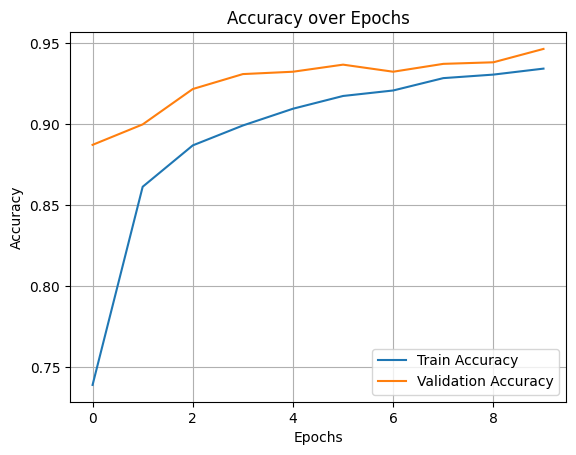

In [13]:
# STEP 7: Evaluate model
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(test_loader)

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.grid(True)
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step

📊 Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.05      0.05      0.05       101
                     Pepper__bell___healthy       0.08      0.09      0.09       149
                      Potato___Early_blight       0.08      0.08      0.08       100
                       Potato___Late_blight       0.05      0.05      0.05       100
                           Potato___healthy       0.00      0.00      0.00        16
                      Tomato_Bacterial_spot       0.11      0.12      0.11       214
                        Tomato_Early_blight       0.03      0.02      0.02       100
                         Tomato_Late_blight       0.10      0.09      0.09       192
                           Tomato_Leaf_Mold       0.02      0.02      0.02        96
                  Tomato_Septoria_leaf_spot       0.09      0.10      0.09       

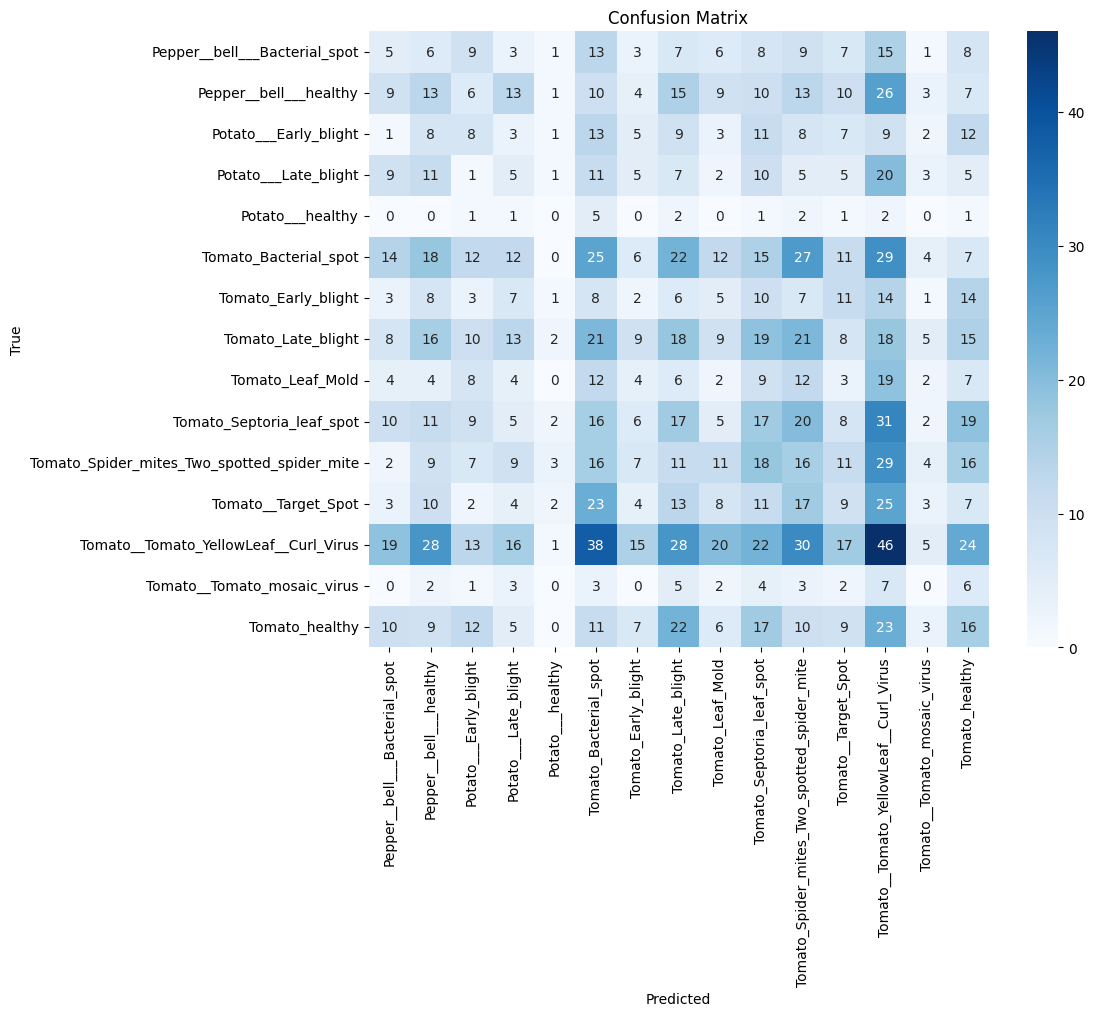

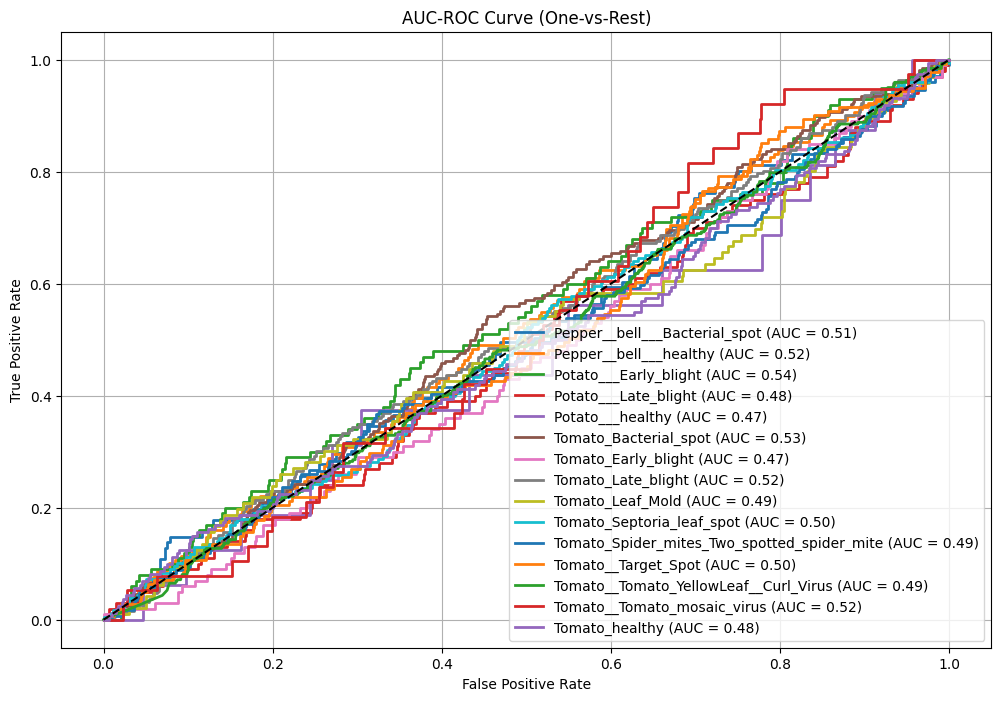

In [14]:
# STEP 8: Classification report, Confusion matrix, AUC
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

y_pred = model.predict(test_loader)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_loader.classes
class_labels = list(test_loader.class_indices.keys())

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# AUC-ROC
y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))

plt.figure(figsize=(12, 8))
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve (One-vs-Rest)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [15]:
# STEP 9: Final metrics summary
model_size_MB = sum([np.prod(v.shape) for v in model.trainable_variables]) * 4 / (1024 ** 2)

print(f"\n✅ Training Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"✅ Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"⏱️ Training Time: {training_time:.2f} seconds")
print(f"📦 Model Size: {model_size_MB:.2f} MB")
print(f"🧮 Macro-average AUC: {roc_auc_score(y_true_bin, y_pred, average='macro'):.4f}")
print(f"🧮 Weighted-average AUC: {roc_auc_score(y_true_bin, y_pred, average='weighted'):.4f}")


✅ Training Accuracy: 93.44%
✅ Validation Accuracy: 94.66%
✅ Test Accuracy: 93.55%
⏱️ Training Time: 506.27 seconds
📦 Model Size: 2.03 MB
🧮 Macro-average AUC: 0.5005
🧮 Weighted-average AUC: 0.5025
